# In this notebook, we show the steps taken to analyze and compare the feature spaces originated from the **isoforms** dataset. Additionally, the shap library is developed to explore the importance of the different features.







*USEFUL LINKS:*

https://towardsdatascience.com/feature-selection-using-regularisation-a3678b71e499

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel

https://towardsdatascience.com/a-novel-approach-to-feature-importance-shapley-additive-explanations-d18af30fc21b

https://shap.readthedocs.io/en/latest/index.html

### Imports section: 


In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/Drive', force_remount=True)

Mounted at /content/Drive


In [ ]:
# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score, f1_score, matthews_corrcoef, classification_report, make_scorer
from sklearn.linear_model import LogisticRegression, Lasso
import matplotlib.pyplot as plt
from xlwt import Workbook
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import os
from sklearn.ensemble import RandomForestClassifier
from pandas_profiling import ProfileReport
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from datetime import datetime
from sklearn.feature_selection import SelectFromModel

In [ ]:
! pip install mrmr_selection
! pip install scikit-learn==0.24.2

In [ ]:
import warnings
warnings.filterwarnings('ignore')
! pip freeze
! pip install --upgrade scikit-learn # Downgrading the scikit learn library to obtain same results of previous experiments and Convergence

### Download of all datasets with different preprocessing strategies and feature spaces

In [ ]:
# Current working directory and other paths
cwd = os.getcwd()
print(cwd)
!cd Drive/
path = cwd + "/Drive/My Drive/magistrale/BioinformaticsProject/data/" ### <- insert here path to retrieve data
results_path = cwd + "/Drive/My Drive/magistrale/BioinformaticsProject/results/" ### <- insert here path to save results

# Count per Million matrix
cpm_dataset = pd.read_csv(path+"CPM.csv",index_col=0) #read the main CPM dataset(67k × 719)
cpm_dataset = cpm_dataset.transpose() # (719 × 67k)
# Training and Testing datasets -> NEW WITH REMOVAL OF SAMPLES NOT AVAILABLE FOR GENE DATA EXPRESSION
training_ds =  pd.read_excel(path+"train_test_new.xlsx", sheet_name="train_new")
testing_ds = pd.read_excel(path+"train_test_new.xlsx", sheet_name="test_new")

# Feature space datesets
base_feature_space =path+"FEATURE_SPACES(RAW +CPM).xlsx"
# List of feature space name 
feature_space_files =["FEATURE_SPACE6(MAIN)", "FEATURE_SPACE1(PAM)", "FEATURE_SPACE2(PAM)","FEATURE_SPACE1(LIMMA)","FEATURE_SPACE2(LIMMA)", "FEATURE_SPACE7(pamsimilarity)","FEATURE_SPACE8(limmasimilarity)"]

/content


In [ ]:
cpm_dataset.head(5)

transcript_id,uc001aab.3,uc001aac.3,uc001aae.3,uc001aah.3,uc001aai.1,uc001aak.2,uc001aal.1,uc001aau.2,uc001aav.3,uc001abe.3,...,uc011nbk.1,uc011nbl.1,uc011nbm.1,uc011nbn.1,uc011nbo.1,uc011nbs.1,uc011nbt.1,uc011nbu.1,uc011nbv.1,uc011nbw.1
TCGA-3C-AAAU,5.195055,0.672913,17.421007,0.000000,54.438856,0.019111,0.0,18.714277,14.426631,1.187965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-3C-AALI,6.797312,0.532043,5.240079,6.452648,37.002506,0.000000,0.0,14.392687,10.248490,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-3C-AALJ,3.198963,2.653702,7.971825,0.000000,47.088828,0.000000,0.0,9.915566,5.127111,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-3C-AALK,5.064226,1.973238,11.828148,0.840518,17.992285,0.000000,0.0,4.443527,6.578962,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-4H-AAAK,3.614929,0.253288,3.782757,0.140887,18.229886,0.000000,0.0,0.000000,7.705960,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Data extraction and preprocessing

In [ ]:
def extract_and_reduce_by_columns(path, sheet_name, name, nofeats_ds, preproc_strategy: str= "none"): 
  """
     Function to extract dataset and a specific group of its columns.

     path: the path where to get the data values (isoforms)
     sheet_name: the excel sheet were to get the columns to select for the data (isoforms)
     nofeats_ds: the dataset without the additional columns
     name: 'trainingset' or 'testingset' for the excel 
     preproc_strategy: which preprocessing strategy to apply to the ds

  """
  full_df = pd.read_excel(path, sheet_name=sheet_name) # path of subdatset 
  full_list= full_df['isoform'].values.tolist()  #exatrct the list of isoforms names as list
  if preproc_strategy == 'loge':
    # https://stackoverflow.com/questions/49538185/purpose-of-numpy-log1p
    log_cpm_dataset = np.log1p(cpm_dataset)
    data = log_cpm_dataset[np.intersect1d(log_cpm_dataset.columns, full_list)]
  elif preproc_strategy == 'log2':
    log_cpm_dataset = np.log2(cpm_dataset + 1) # constant added to avoid reaching zero
    data = log_cpm_dataset[np.intersect1d(log_cpm_dataset.columns, full_list)]
  elif preproc_strategy == 'normperrow':
    # normalize per rows
    data = cpm_dataset[np.intersect1d(cpm_dataset.columns, full_list)]
    data = data.div(data.sum(axis=1), axis=0) # ----> preprocessing scaling step to try, not working
  elif preproc_strategy == 'none':
    data = cpm_dataset[np.intersect1d(cpm_dataset.columns, full_list)]  # find the mutual isoform between main datset and subdatset 
  
  data.reset_index(inplace=True)
  data.rename(columns={ data.columns[0]: "sample_id" }, inplace = True)

  x = nofeats_ds['sample_id'].values.tolist()
  data1= data.loc[data['sample_id'].isin(x)]
  result = pd.merge(data1, nofeats_ds, on='sample_id')
  result
  result.rename(columns={'sample_label':'subtype'}, inplace=True )
 
  # result.to_csv(name +".csv", index=False) # save as csv file 
  return result

### Download of all datasets with different preprocessing strategies and feature spaces

In [ ]:
# List of feature space name 
feature_space_files =["FEATURE_SPACE6(MAIN)", "FEATURE_SPACE1(PAM)", "FEATURE_SPACE2(PAM)","FEATURE_SPACE1(LIMMA)","FEATURE_SPACE2(LIMMA)", "FEATURE_SPACE7(pamsimilarity)","FEATURE_SPACE8(limmasimilarity)"]

DATASET with PAM50 Feature Space 
 

In [ ]:
# Training Data import:
train = extract_and_reduce_by_columns(base_feature_space, "FEATURE_SPACE7(pamsimilarity)", 'trainingset', training_ds, 'none') 
X_train_pam = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_pam =train.subtype
print("X_train size:", X_train_pam.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(base_feature_space, "FEATURE_SPACE7(pamsimilarity)",'testingset', testing_ds,'none' ) 
X_test_pam = test.drop(["sample_id","subtype"], axis = 1)
Y_test_pam = test.subtype
print("X_test size:", X_test_pam.shape)

X_train size: (410, 131)
X_test size: (127, 131)


DATASET with LIMMA50 Feature Space

In [ ]:
# Training Data import:
train = extract_and_reduce_by_columns(base_feature_space, "FEATURE_SPACE8(limmasimilarity)", 'trainingset', training_ds, 'none' ) 
X_train_limma = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_limma =train.subtype
print("X_train size:", X_train_limma.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(base_feature_space, "FEATURE_SPACE8(limmasimilarity)",'testingset', testing_ds, 'none') 
X_test_limma = test.drop(["sample_id","subtype"], axis = 1)
Y_test_limma = test.subtype
print("X_test size:", X_test_limma.shape)

X_train size: (410, 557)
X_test size: (127, 557)


DATASET with PAM50 Feature Space and LOG2 PREPROCESSING

In [ ]:
# Training Data import:
train = extract_and_reduce_by_columns(base_feature_space, "FEATURE_SPACE7(pamsimilarity)", 'trainingset', training_ds, 'log2') 
X_train_pam_log2 = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_pam_log2 =train.subtype
print("X_train size:", X_train_pam_log2.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(base_feature_space, "FEATURE_SPACE7(pamsimilarity)",'testingset', testing_ds,'log2' ) 
X_test_pam_log2 = test.drop(["sample_id","subtype"], axis = 1)
Y_test_pam_log2 = test.subtype
print("X_test size:", X_test_pam_log2.shape)

X_train size: (410, 131)
X_test size: (127, 131)


DATASET with LIMMA50 Feature Space and LOG2 PREPROCESSING

In [ ]:
# Training Data import:
train = extract_and_reduce_by_columns(base_feature_space, "FEATURE_SPACE8(limmasimilarity)", 'trainingset', training_ds, 'log2' ) 
X_train_limma_log2 = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_limma_log2 =train.subtype
print("X_train size:", X_train_limma_log2.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(base_feature_space, "FEATURE_SPACE8(limmasimilarity)",'testingset', testing_ds, 'log2') 
X_test_limma_log2 = test.drop(["sample_id","subtype"], axis = 1)
Y_test_limma_log2 = test.subtype
print("X_test size:", X_test_limma_log2.shape)

X_train size: (410, 557)
X_test size: (127, 557)




##### Feature selection is done on a feature space which has been filtered only with some basic noise-removal steps (from 67k to 49k)

In [ ]:
# Here the train and test set are created with the initial filterings to reach 49k features is 
# Training Data import:
train = extract_and_reduce_by_columns(base_feature_space, "FEATURE_SPACE6(MAIN)", 'trainingset', training_ds, 'log2') 
X_train_49kfs = train.drop(["sample_id","subtype"],  axis = 1)
samples_train = train.sample_id
Y_train_49kfs=train.subtype
print("X_train size:", X_train_49kfs.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(base_feature_space,"FEATURE_SPACE6(MAIN)", 'testingset', testing_ds,  'log2') 
X_test_49kfs = test.drop(["sample_id","subtype"], axis = 1)
Y_test_49kfs = test.subtype
print("X_test size:", X_test_49kfs.shape)

X_train size: (410, 49740)
X_test size: (127, 49740)


Feature space with features selected through lasso from initial 49k feature space

In [ ]:
# Load previosly generated and saved current feature space
selected_feat = pd.read_csv(path+"isoformsfs/lasso1767.csv", index_col=0,skiprows=1, names=['isoform_id'])
selected_feat= selected_feat['isoform_id'].tolist()

In [ ]:
X_train_lasso = X_train_49kfs[selected_feat].copy()
Y_train_lasso = Y_train_49kfs

X_test_lasso = X_test_49kfs[selected_feat].copy()
Y_test_lasso = Y_test_49kfs

*New feature space exploration and comparison with fs filtered with pam50 and limma50:*

In [ ]:
# Now check how many of the selected features is in either pam50 or limma50 feature space

# pam50 features
pam50_feats = X_train_pam.columns
print("Total number of pam50 features: ",len(pam50_feats))
print("Total number of selected features with lasso: ",len(selected_feat))
i = 0
for p in pam50_feats:
  if p in selected_feat:
    i+=1

print("Number of features from pam50 feature space which were selected with lasso selection: ", i)
# limma50 features
limma50_feats = X_train_limma.columns
print("Total number oflimma50 features: ",len(limma50_feats))
print("Total number of selected features with lasso: ",len(selected_feat))
i = 0
for p in limma50_feats:
  if p in selected_feat:
    i+=1

print("Number of features from pam50 feature space which were selected with lasso selection: ", i)
print("Number of features from limma50 and pam50 feature spaces which were selected with lasso selection: ",len(pam50_feats.intersection(limma50_feats.intersection(selected_feat))) )

Total number of pam50 features:  131
Total number of selected features with lasso:  1767
Number of features from pam50 feature space which were selected with lasso selection:  64
Total number oflimma50 features:  557
Total number of selected features with lasso:  1767
Number of features from pam50 feature space which were selected with lasso selection:  159
Number of features from limma50 and pam50 feature spaces which were selected with lasso selection:  43


#### DATASET with features selected through thresholds on fisher scores or mutual information scores, initially with chosen threshold 97% percentile

In [ ]:
# Load saved feature space
fisher_score_selected_index = pd.read_csv(path+"isoformsfs/fisher_th97.csv", index_col=0,skiprows=1, names=['isoform_id'])
fisher_score_selected_index= fisher_score_selected_index['isoform_id'].tolist()

In [ ]:
# Creating the new dataframe with only the chosen features by this method -> THRESHOLD CHOSEN IS THE 95% percentile value
selected_col_names =fisher_score_selected_index
X_train_fisher_97 = X_train_49kfs[selected_col_names]

print(X_train_fisher_97.shape)
X_test_fisher_97 = X_test_49kfs[selected_col_names]
print(X_test_fisher_97.shape)

# Y of the datasets remain the same
Y_train_fisher_97 = Y_train_49kfs
Y_test_fisher_97 = Y_test_49kfs

(410, 1493)
(127, 1493)


### Feature spaces from scores with mutual information

In [ ]:
# Load saved feature space
mi_score_selected_index = pd.read_csv(path+"isoformsfs/mutualinformation_th97.csv", index_col=0,skiprows=1, names=['isoform_id'])
mi_score_selected_index= mi_score_selected_index['isoform_id'].tolist()

In [ ]:
selected_col_names = mi_score_selected_index
X_train_mi_97 = X_train_49kfs[selected_col_names]
print(X_train_mi_97.shape)

X_test_mi_97 = X_test_49kfs[selected_col_names]
print(X_test_mi_97.shape)

Y_train_mi_97 = Y_train_49kfs
Y_test_mi_97 = Y_test_49kfs

(410, 1493)
(127, 1493)


#### Feature Space with ReRa on PAM50-log2 feature space

In [ ]:
# Load saved feature space
sbf_pam = pd.read_csv(path+"/isoformsfs/sbf_pam.csv", index_col=0,skiprows=1, names=['isoform_id'])
sbf_pam = sbf_pam['isoform_id'].tolist()

In [ ]:
selected_col_names = sbf_pam
# New x train dataset with only the selected features
X_train_pam_sbf = X_train_49kfs[selected_col_names]
print("Shape of the new train dataset", X_train_pam_sbf.shape)

test_selected_col_names = sbf_pam
# New x test dataset with only the selected features
X_test_pam_sbf = X_test_49kfs[selected_col_names]
print("Shape of the new test dataset",X_test_pam_sbf.shape)

Shape of the new train dataset (410, 129)
Shape of the new test dataset (127, 129)


#### Feature Space with ReRa on LIMMA50 log2 feature space

In [ ]:
# Load saved feature space
sbf_limma = pd.read_csv(path+"/isoformsfs/sbf_limma.csv", index_col=0,skiprows=1, names=['isoform_id'])
sbf_limma = sbf_limma['isoform_id'].tolist()

In [ ]:
selected_col_names = sbf_limma
X_train_limma_sbf = X_train_49kfs[selected_col_names]
print("Shape of the new train dataset", X_train_limma_sbf.shape)

test_selected_col_names = sbf_limma
X_test_limma_sbf = X_test_49kfs[selected_col_names]
print("Shape of the new test dataset",X_test_limma_sbf.shape)

Shape of the new train dataset (410, 533)
Shape of the new test dataset (127, 533)


#### FS with ReRa on Fisher log2 feature space

In [ ]:
# Load saved feature space
sbf_fisher = pd.read_csv(path+"/isoformsfs/sbf_fisher_th97.csv", index_col=0,skiprows=1, names=['isoform_id'])
sbf_fisher = sbf_fisher['isoform_id'].tolist()

In [ ]:
selected_col_names = sbf_fisher
X_train_fisher_sbf_97 = X_train_49kfs[selected_col_names]
print(X_train_fisher_sbf_97.shape)

test_selected_col_names =sbf_fisher
X_test_fisher_sbf_97 = X_test_49kfs[selected_col_names]
print(X_test_fisher_sbf_97.shape)

(410, 1208)
(127, 1208)


Feature Space with ReRa selection on Mutual Info log2 feature space

In [ ]:
# Load saved feature space
mi_sbf = pd.read_csv(path+"/isoformsfs/sbf_mi_th97.csv", index_col=0,skiprows=1, names=['isoform_id'])
mi_sbf = mi_sbf['isoform_id'].tolist()

In [ ]:
selected_col_names =mi_sbf
X_train_mi_sbf_97 = X_train_49kfs[selected_col_names]
print("Shape of the new train dataset", X_train_mi_sbf_97.shape)

test_selected_col_names = mi_sbf
X_test_mi_sbf_97 = X_test_49kfs[selected_col_names]
print("Shape of the new test dataset",X_test_mi_sbf_97.shape)

Shape of the new train dataset (410, 1264)
Shape of the new test dataset (127, 1264)


### Feature Spaces 98% percentile threshold for fisher scores and mutual information scores

In [ ]:
# Load saved feature space
fisher_score_selected_index = pd.read_csv(path+"isoformsfs/fisher_th98.csv", index_col=0,skiprows=1, names=['isoform_id'])
fisher_score_selected_index= fisher_score_selected_index['isoform_id'].tolist()

In [ ]:
# Creating the new dataframe with only the chosen features by this method -> THRESHOLD CHOSEN IS THE 95% percentile value
selected_col_names =fisher_score_selected_index
X_train_fisher_98 = X_train_49kfs[selected_col_names]

print(X_train_fisher_98.shape)
X_test_fisher_98 = X_test_49kfs[selected_col_names]
print(X_test_fisher_98.shape)

# Y of the datasets remain the same
Y_train_fisher_98 = Y_train_49kfs
Y_test_fisher_98 = Y_test_49kfs

(410, 995)
(127, 995)


#### Feature spaces from scores with mutual information

In [ ]:
# Load saved feature space
mi_score_selected_index = pd.read_csv(path+"isoformsfs/mutualinformation_th98.csv", index_col=0,skiprows=1, names=['isoform_id'])
mi_score_selected_index= mi_score_selected_index['isoform_id'].tolist()

In [ ]:
selected_col_names = mi_score_selected_index
X_train_mi_98 = X_train_49kfs[selected_col_names]
print(X_train_mi_98.shape)

X_test_mi_98 = X_test_49kfs[selected_col_names]
print(X_test_mi_98.shape)

Y_train_mi_98 = Y_train_49kfs
Y_test_mi_98 = Y_test_49kfs

(410, 995)
(127, 995)


### Feature Space with ReRa on Fisher  log2

In [ ]:
# Load saved feature space
sbf_fisher = pd.read_csv(path+"/isoformsfs/sbf_fisher_th98.csv", index_col=0,skiprows=1, names=['isoform_id'])
sbf_fisher = sbf_fisher['isoform_id'].tolist()

In [ ]:
selected_col_names = sbf_fisher
X_train_fisher_sbf_98 = X_train_49kfs[selected_col_names]
print(X_train_fisher_sbf_98.shape)

test_selected_col_names =sbf_fisher
X_test_fisher_sbf_98 = X_test_49kfs[selected_col_names]
print(X_test_fisher_sbf_98.shape)

(410, 792)
(127, 792)


### Feature Space with ReRa on Mutual Info log2

In [ ]:
# Load saved feature space
mi_sbf = pd.read_csv(path+"/isoformsfs/sbf_mi_th98.csv", index_col=0,skiprows=1, names=['isoform_id'])
mi_sbf = mi_sbf['isoform_id'].tolist()

In [ ]:
selected_col_names =mi_sbf
X_train_mi_sbf_98 = X_train_49kfs[selected_col_names]
print("Shape of the new train dataset", X_train_mi_sbf_98.shape)

test_selected_col_names = mi_sbf
X_test_mi_sbf_98 = X_test_49kfs[selected_col_names]
print("Shape of the new test dataset",X_test_mi_sbf_98.shape)

Shape of the new train dataset (410, 887)
Shape of the new test dataset (127, 887)


### threshold at 99% percentile of values for selection from fisher scores and mutual information scores

In [ ]:
# Load saved feature space
fisher_score_selected_index = pd.read_csv(path+"isoformsfs/fisher_th99.csv", index_col=0,skiprows=1, names=['isoform_id'])
fisher_score_selected_index= fisher_score_selected_index['isoform_id'].tolist()

In [ ]:
# Creating the new dataframe with only the chosen features by this method -> THRESHOLD CHOSEN IS THE 95% percentile value
selected_col_names =fisher_score_selected_index
X_train_fisher_99 = X_train_49kfs[selected_col_names]

print(X_train_fisher_99.shape)
X_test_fisher_99 = X_test_49kfs[selected_col_names]
print(X_test_fisher_99.shape)

# Y of the datasets remain the same
Y_train_fisher_99 = Y_train_49kfs
Y_test_fisher_99 = Y_test_49kfs

(410, 498)
(127, 498)


### Feature spaces selected from scores with mutual information

In [ ]:
# Load saved feature space
mi_score_selected_index = pd.read_csv(path+"isoformsfs/mutualinformation_th99.csv", index_col=0,skiprows=1, names=['isoform_id'])
mi_score_selected_index= mi_score_selected_index['isoform_id'].tolist()

In [ ]:
selected_col_names = mi_score_selected_index
X_train_mi_99 = X_train_49kfs[selected_col_names]
print(X_train_mi_99.shape)

X_test_mi_99 = X_test_49kfs[selected_col_names]
print(X_test_mi_99.shape)

Y_train_mi_99 = Y_train_49kfs
Y_test_mi_99 = Y_test_49kfs

(410, 498)
(127, 498)


### FS with ReRa selection on Fisher  log2

In [ ]:
# Load saved feature space
sbf_fisher = pd.read_csv(path+"/isoformsfs/sbf_fisher_th99.csv", index_col=0,skiprows=1, names=['isoform_id'])
sbf_fisher = sbf_fisher['isoform_id'].tolist()

In [ ]:
selected_col_names = sbf_fisher
X_train_fisher_sbf_99 = X_train_49kfs[selected_col_names]
print(X_train_fisher_sbf_99.shape)

test_selected_col_names =sbf_fisher
X_test_fisher_sbf_99 = X_test_49kfs[selected_col_names]
print(X_test_fisher_sbf_99.shape)

(410, 393)
(127, 393)


### Feature Space with ReRa selection on Mutual Info features log2

In [ ]:
# output will be the list of selected features
mi_sbf = pd.read_csv(path+"/isoformsfs/sbf_mi_th99.csv", index_col=0,skiprows=1, names=['isoform_id'])
mi_sbf = mi_sbf['isoform_id'].tolist()

In [ ]:
selected_col_names =mi_sbf
X_train_mi_sbf_99 = X_train_49kfs[selected_col_names]
print("Shape of the new train dataset", X_train_mi_sbf_99.shape)

test_selected_col_names = mi_sbf
X_test_mi_sbf_99 = X_test_49kfs[selected_col_names]
print("Shape of the new test dataset",X_test_mi_sbf_99.shape)

Shape of the new train dataset (410, 440)
Shape of the new test dataset (127, 440)


#### *Fisher score feature space exploration and comparison with fs filtered with pam50 and limma50:*

In [ ]:
# Now check how many of the selected features is in either pam50 or limma50 feature space

print("FISHER SCORE FEATURE SPACE THRESHOLD AT 98% of scores")
# pam50 features
pam50_feats = X_train_pam.columns
print("Total number of pam50 features: ",len(pam50_feats))
print("Total number of selected features with Fisher score: ",len(X_train_fisher.columns))
i = 0
for p in pam50_feats:
  if p in X_train_fisher.columns:
    i+=1

print("Number of features from pam50 feature space which were selected with Fisher score: ", i)

# limma50 features
limma50_feats = X_train_limma.columns
print("Total number of limma50 features: ",len(limma50_feats))
print("Total number of selected features with Fisher score: ",len(X_train_fisher.columns))
j = 0
for p in limma50_feats:
  if p in X_train_fisher.columns:
    j+=1

print("Number of features from limma50 feature space which were selected with Fisher score: ", j)

print("Number of features from limma50 and pam50 feature spaces which were selected with Fisher score selection: ",len(pam50_feats.intersection(limma50_feats.intersection(X_train_fisher.columns))) )

FISHER SCORE FEATURE SPACE THRESHOLD AT 98% of scores
Total number of pam50 features:  131
Total number of selected features with Fisher score:  1493
Number of features from pam50 feature space which were selected with Fisher score:  13
Total number of limma50 features:  557
Total number of selected features with Fisher score:  1493
Number of features from limma50 feature space which were selected with Fisher score:  24
Number of features from limma50 and pam50 feature spaces which were selected with Fisher score selection:  10


#### *Mutual Information feature space exploration and comparison with fs filtered with pam50 and limma50:*

In [ ]:
# Now check how many of the selected features is in either pam50 or limma50 feature space
print("MUTUAL INFO FEATURE SPACE THRESHOLD AT 98% of scores")
# pam50 features
pam50_feats = X_train_pam.columns
print("Total number of pam50 features: ",len(pam50_feats))
print("Total number of selected features with mutual info: ",len(X_train_mi.columns))
i = 0
for p in pam50_feats:
  if p in X_train_mi.columns:
    i+=1

print("Number of features from pam50 feature space which were selected with mutual info: ", i)

# limma50 features
limma50_feats = X_train_limma.columns
print("Total number of limma50 features: ",len(limma50_feats))
print("Total number of selected features with mutual info: ",len(X_train_mi.columns))
j = 0
for p in limma50_feats:
  if p in X_train_mi.columns:
    j+=1

print("Number of features from limma50 feature space which were selected with mutual info: ", j)

print("Number of features from limma50 and pam50 feature spaces which were selected with mutual info selection: ",len(pam50_feats.intersection(limma50_feats.intersection(X_train_mi.columns))) )

MUTUAL INFO FEATURE SPACE THRESHOLD AT 98% of scores
Total number of pam50 features:  131
Total number of selected features with mutual info:  1493
Number of features from pam50 feature space which were selected with mutual info:  78
Total number of limma50 features:  557
Total number of selected features with mutual info:  1493
Number of features from limma50 feature space which were selected with mutual info:  260
Number of features from limma50 and pam50 feature spaces which were selected with mutual info selection:  55


###minimum Redundancy - Maximum Relevance

For the isoforms, the entire feature space of 49790 features is too big for the mrmr selection and it exceeds the ram space. 
For this reason, a reduction to at least 15k features is computed as preprocessing step.

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [ ]:
! pip install sklearn --version 0.23.2

In [ ]:
# Due to the high dimensionality of the rera feature space to explore, a selected number of samples has to be chosen to perform the exploration and explainability
selector = SelectKBest(f_classif, k=12000)
X_train_12k = selector.fit_transform(X_train_49kfs, Y_train_49kfs)
selector.get_feature_names_out()

array(['uc001abx.1', 'uc001ads.2', 'uc001aew.2', ..., 'uc011mzd.1',
       'uc011mzn.1', 'uc011mzp.1'], dtype=object)

In [ ]:
X_train_12k = pd.DataFrame(X_train_49kfs[list(selector.get_feature_names_out())])
X_train_12k

In [ ]:
import mrmr
# select top K features using mRMR
from mrmr import mrmr_classif

In [ ]:
# mrmr_features = mrmr_classif(X=X_train_12k, y= Y_train_49kfs, K=500)
# Next steps: check how many of the chosen features overlap with selected with lasso, pam50 and limam50
# in other training notebook: check how the models perform on it 

100%|██████████| 500/500 [21:51<00:00,  2.62s/it]


In [ ]:
mrmr_features = pd.read_csv(path+"isoformsfs/mrmr750_from12k.csv", index_col=0,skiprows=1, names=['isoform_id'])
mrmr_features = mrmr_features['isoform_id'].tolist()

In [ ]:
X_train_mrmr =  X_train_49kfs[mrmr_features].copy()
Y_train_mrmr = Y_train_49kfs

X_test_mrmr =  X_test_49kfs[mrmr_features].copy()
Y_test_mrmr = Y_test_49kfs
print(X_train_mrmr.shape, X_test_mrmr.shape)

(410, 750) (127, 750)


In [ ]:
# pd.DataFrame(X_train_mrmr.columns).to_csv(path+"isoformsfs/mrmr500_from12k.csv")

#### mrmr with dimension 500 features

In [ ]:
selected_feat = pd.read_csv(path+"/isoformsfs/mrmr500_from12k.csv", index_col=0,skiprows=1, names=['isoforms_id'])
selected_feat = selected_feat['isoforms_id'].tolist()

In [ ]:
X_train_mrmr_500 = X_train_49kfs[selected_feat].copy()
Y_train_mrmr_500 =  Y_train_49kfs

X_test_mrmr_500 = X_test_49kfs[selected_feat].copy()
Y_test_mrmr_500 = Y_test_49kfs

In [ ]:
print(X_train_mrmr_500.shape, X_test_mrmr_500.shape)

(410, 500) (127, 500)


dimension: 1000 features

In [ ]:
selected_feat = pd.read_csv(path+"/isoformsfs/mrmr1000_from12k.csv", index_col=0,skiprows=1, names=['isoform_id'])
selected_feat = selected_feat['isoform_id'].tolist()

In [ ]:
X_train_mrmr_1000 = X_train_49kfs[selected_feat].copy()
Y_train_mrmr_1000 =  Y_train_49kfs

X_test_mrmr_1000 = X_test_49kfs[selected_feat].copy()
Y_test_mrmr_1000 = Y_test_49kfs

In [ ]:
print(X_train_mrmr_1000.shape, X_test_mrmr_1000.shape)

(410, 1000) (127, 1000)


### Load the 10 feature spaces with randomly selected features 

In [ ]:
# Commented after generation the random feature spaces
'''import random
random_feature_spaces = []
X_train_randoms = []
X_test_randoms =[]

for i in range(10):
  random_fs = random.sample(list(X_train_49kfs.columns), 887)
  random_feature_spaces.append(random_fs)

  selected_col_names =random_fs
  X_train_random = X_train_49kfs[selected_col_names]
  print("Shape of the new train dataset", X_train_random.shape)

  test_selected_col_names = random_fs
  X_test_random = X_test_49kfs[selected_col_names]
  print("Shape of the new test dataset",X_test_random.shape)

  X_train_randoms.append(X_train_random)
  X_test_randoms.append(X_test_random)'''

In [ ]:
dic_intersect = {}
for x,name in zip(random_feature_spaces, range(10)):
  dic_intersect[name]= []
  for y in random_feature_spaces:
    dic_intersect[name].append(len(set(x).intersection(y)))
  
  print(f"Number of isforms intersected with the others in feature space : {name} is { dic_intersect[name]}")

Number of isforms intersected with the others in feature space : 0 is [887, 21, 13, 19, 20, 12, 13, 10, 18, 19]
Number of isforms intersected with the others in feature space : 1 is [21, 887, 24, 12, 10, 17, 16, 17, 17, 14]
Number of isforms intersected with the others in feature space : 2 is [13, 24, 887, 23, 11, 13, 15, 22, 18, 13]
Number of isforms intersected with the others in feature space : 3 is [19, 12, 23, 887, 11, 15, 15, 14, 19, 20]
Number of isforms intersected with the others in feature space : 4 is [20, 10, 11, 11, 887, 15, 15, 16, 15, 18]
Number of isforms intersected with the others in feature space : 5 is [12, 17, 13, 15, 15, 887, 13, 13, 22, 19]
Number of isforms intersected with the others in feature space : 6 is [13, 16, 15, 15, 15, 13, 887, 15, 15, 13]
Number of isforms intersected with the others in feature space : 7 is [10, 17, 22, 14, 16, 13, 15, 887, 16, 15]
Number of isforms intersected with the others in feature space : 8 is [18, 17, 18, 19, 15, 22, 15, 16, 8

In [ ]:
Y_train_random = Y_train_49kfs
Y_test_random = Y_test_49kfs

In [ ]:
X_train_randoms = []
random_spaces_names = []
X_test_randoms = []

for i in range(10):
  rand_selected_feat = pd.read_csv(path+"isoformsfs/random_"+str(i)+".csv", index_col=0,skiprows=1, names=['isoform_id'])
  rand_selected_feat = rand_selected_feat['isoform_id'].tolist()

  selected_col_names =rand_selected_feat
  X_train_random = X_train_49kfs[selected_col_names]
  print("Shape of the new train dataset", X_train_random.shape)
  X_test_random = X_test_49kfs[selected_col_names]
  print("Shape of the new test dataset",X_test_random.shape)

  X_train_randoms.append(X_train_random)
  X_test_randoms.append(X_test_random)
  random_spaces_names.append("random"+str(i))

Shape of the new train dataset (410, 887)
Shape of the new test dataset (127, 887)
Shape of the new train dataset (410, 887)
Shape of the new test dataset (127, 887)
Shape of the new train dataset (410, 887)
Shape of the new test dataset (127, 887)
Shape of the new train dataset (410, 887)
Shape of the new test dataset (127, 887)
Shape of the new train dataset (410, 887)
Shape of the new test dataset (127, 887)
Shape of the new train dataset (410, 887)
Shape of the new test dataset (127, 887)
Shape of the new train dataset (410, 887)
Shape of the new test dataset (127, 887)
Shape of the new train dataset (410, 887)
Shape of the new test dataset (127, 887)
Shape of the new train dataset (410, 887)
Shape of the new test dataset (127, 887)
Shape of the new train dataset (410, 887)
Shape of the new test dataset (127, 887)


In [ ]:
# Now check how many of the selected features is in either pam50 or limma50 feature space

print("Total number of mrmr features: ", len(mrmr_features), "\n")

# pam50 features
pam50_feats = X_train_pam.columns
print("Total number of pam50 features: ", len(pam50_feats))
print("Total number of selected features with mrmr: ", len(mrmr_features))
print("Number of features from pam50 feature space which were selected with lasso selection: ", len(set(pam50_feats).intersection(selected_feat)))
print("Number of common features between pam50 and mrmr:", len(set(pam50_feats).intersection(mrmr_features)), "\n")

# limma50 features
limma50_feats = X_train_limma.columns
print("Total number of limma50 features: ", len(limma50_feats))
print("Total number of selected features with mrmr: ", len(mrmr_features))
print("Number of features from limma50 feature space which were selected with lasso selection: ", len(set(limma50_feats).intersection(selected_feat)))
print("Number of common features between limma50 and mrmr:", len(set(limma50_feats).intersection(mrmr_features)), "\n")

# mrmr and lasso
print("Total number of selected features with lasso: ", len(selected_feat))
print("Number of common features between lasso and mrmr:", len(set(selected_feat).intersection(mrmr_features)), "\n")

# Combinations
print("Number of features from limma50 and pam50 feature spaces which were selected with lasso selection: ", len(pam50_feats.intersection(limma50_feats.intersection(selected_feat))) )
print("Number of common features between limma50, pam50 and mrmrset: ", len(set(pam50_feats.intersection(limma50_feats.intersection(selected_feat))).intersection(mrmr_features) ))

In [ ]:
def create_evaluation( y_pred: int, y_test: int, labels, name):

  return [ name,
          round(balanced_accuracy_score(y_test, y_pred), 3), 
          round(accuracy_score(y_test, y_pred), 3),
          round(precision_score(y_test, y_pred, average="macro"), 3),
          round(f1_score(y_test, y_pred, average="macro"),3),
          round(recall_score(y_test, y_pred, average="macro"), 3),
          round(f1_score(y_test, y_pred, average="micro"),3)]

### Shapley explanation for Feature importace

In [ ]:
! pip install -q shap
import shap

In [ ]:
samples_per_class = {'Basal': 16, 'Normal': 4, 'LumA': 50, 'LumB': 22, 'Her2': 8}

# Perform stratified sampling
sampled_indices = []
for target_value, n_samples in samples_per_class.items():
    print(target_value)
    # Get the indices of rows with the current target value
    indices = Y_train_49kfs[Y_train_49kfs == target_value].index
    # Select n_samples indices at random
    sampled_indices.extend(train_test_split(indices, train_size=n_samples, stratify=Y_train_49kfs.loc[indices])[0])

# Create the new Series with the sampled rows
sampled_s = Y_train_49kfs.loc[sampled_indices]

# Print the number of samples for each class in the new Series
print(sampled_s)
# Output: 
# LumA      144
# LumB       65
# Basal      47
# HER2       24
# Normal     10
Y_train_sampled = sampled_s
X_train_sampled = X_train_mi_sbf_98.loc[sampled_indices]

In [ ]:
from sklearn.model_selection import train_test_split

# print the JS visualization code to the notebook
shap.initjs()

# train a SVM classifier
X_train,X_test,Y_train,Y_test = X_train_sampled, X_test_mi_sbf_98, Y_train_sampled, Y_test_49kfs
SVC_trained = SVC(random_state=0, C=0.01,gamma=0.1, degree= 2, kernel = 'poly', max_iter=2000,  probability=True).fit(X_train, Y_train )
y_pred=SVC_trained.predict(X_test)


# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(SVC_trained.predict_proba , X_train) # shap.sample(X_train, 10))
shap_values = explainer.shap_values(X_test)
 

  0%|          | 0/127 [00:00<?, ?it/s]

In [ ]:
shap_values = explainer.shap_values(X_test)

  0%|          | 0/127 [00:00<?, ?it/s]

In [ ]:
def get_ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
 
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    
    k2_f = k2[['Variable', 'SHAP_abs', 'Corr']]
    k2_f['SHAP_abs'] = k2_f['SHAP_abs'] * np.sign(k2_f['Corr'])
    k2_f.drop(columns='Corr', inplace=True)
    k2_f.rename(columns={'SHAP_abs': 'SHAP'}, inplace=True)
    return k2_f


In [ ]:
import plotly.express as px

In [ ]:
shap_all = pd.DataFrame()

for k,v in list(enumerate(SVC_trained.classes_)):
    # print(k)
    shap_single_class = get_ABS_SHAP(shap_values[k], X_test)
    shap_single_class['class'] = v
    shap_all = pd.concat([shap_all,shap_single_class])

px.bar(shap_all,x='SHAP', y='Variable', color='class')

In [ ]:
# shap_all.to_excel(path+'shap/isoforms/shap_contirbution_noabs.xlsx')

In [ ]:
import plotly.offline as pyo

fig = px.bar(shap_all,x='SHAP', y='Variable', color='class')
fig.write_html( path+'shap/bar1_chart_isoforms.html')

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:])

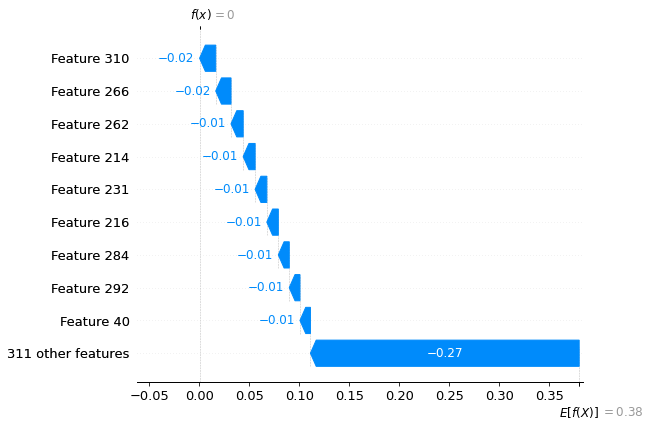

In [ ]:
# https://stackoverflow.com/questions/65029216/how-to-interpret-base-value-of-multi-class-classification-problem-when-using-sha/65034362#65034362
from shap import Explanation
shap.waterfall_plot(Explanation(shap_values[0][0],explainer.expected_value[0]))

In [ ]:
pd.DataFrame(shap_values[0]).to_excel(path+'shap/'+ SVC_trained.classes_[0]+'.xlsx')
pd.DataFrame(shap_values[1]).to_excel(path+'shap/'+ SVC_trained.classes_[1]+'.xlsx')
pd.DataFrame(shap_values[2]).to_excel(path+'shap/'+ SVC_trained.classes_[2]+'.xlsx')
pd.DataFrame(shap_values[3]).to_excel(path+'shap/'+ SVC_trained.classes_[3]+'.xlsx')
pd.DataFrame(shap_values[4]).to_excel(path+'shap/'+ SVC_trained.classes_[4]+'.xlsx')

In [ ]:
# vals= np.abs(shap_values).mean(0)
shap_abs = np.abs(shap_values)
k = shap_abs.mean(1)
feature_importance = pd.DataFrame(list(zip(X_train.columns, sum(k))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(100)

,col_name,feature_importance_vals
196,uc001lci.2,0.026136
200,uc002zax.1,0.021495
377,uc001san.2,0.017711
153,uc001iza.1,0.017225
691,uc011kyf.1,0.015685
...,...,...
86,uc009xee.2,0.005656
697,uc001ise.1,0.005552
689,uc010yvs.1,0.005550
360,uc004clp.2,0.005550


In [ ]:
# feature_importance.to_excel(path+'shap/feature_importance_scores_isoforms.xlsx')

In [ ]:
f=plt.figure()
shap.summary_plot(shap_values, features=X_test, feature_names=X_train.columns, max_display=100, class_names= np.unique(SVC_trained.classes_))
f.savefig(path+"/isoforms_summary_plot.png", bbox_inches='tight', dpi=600)

### Add details related to number of genes associated to the isoforms chosen for each feature space




In [ ]:
# # all_X_train =[ X_train_lasso, X_train_mrmr]

feature_spaces_names = [ 'sbf_mi_98th']

In [ ]:
 # https://stackoverflow.com/questions/39770376/scikit-learn-get-accuracy-scores-for-each-class
all_X_train = [X_train_mi_sbf_98, 
              X_train_lasso,
               X_train_mrmr_500,
               X_train_mrmr, 
               X_train_mrmr_1000,
               X_train_pam_log2,
               X_train_pam_sbf, 
               X_train_limma_log2, 
               X_train_limma_sbf,
               X_train_fisher_99,
               X_train_fisher_sbf_99,
               X_train_fisher_98, 
               X_train_fisher_sbf_98, 
               X_train_fisher_97, 
               X_train_fisher_sbf_97,
               X_train_mi_99, 
               X_train_mi_sbf_99,
               X_train_mi_98, 
               X_train_mi_97, 
               X_train_mi_sbf_97+

               
all_Y_train = [ Y_train_49kfs, Y_train_pam_log2, Y_train_limma_log2,  Y_train_lasso, Y_train_fisher_97]


all_X_test = [ X_test_mi_sbf_98,  X_test_pam_log2, X_test_limma_log2, X_test_lasso,X_test_fisher_97,X_test_mi_97 ] #mrmr msising
all_Y_test = [ Y_test_49kfs, Y_pam_log2,Y_test_limma_log2, Y_test_lasso,Y_test_fisher_97,Y_test_mi_97 ] #mrmr msising

feature_spaces_names = ['mi_sbf_98th', 'full_lasso', 'mrmr500', 'mrmr750','mrmr1000', 'pam_log2',  'sbf_pam','limma_log2', 'sbf_limma', 'fisher99', 'sbf_fisher99','fisher98', 'sbf_fisher98','fisher97', 'sbf_fisher97', 'mi99',  'sbf_mi99', 'mi98',  'sbf_mi98', 'mi97',  'sbf_mi97'] #mrmr

print(Y_test_49kfs.unique())

['LumA' 'Basal' 'LumB' 'Normal' 'Her2']


In [ ]:
all_X_train = all_X_train + X_train_randoms
feature_spaces_names = feature_spaces_names + random_spaces_names

In [ ]:
# the gene symbols associated to the isoforms are in the excel sheets 
# we retrieve them from there and intersect the isoforms with the columns of the X values for each fs

full_df = pd.read_excel(base_feature_space, sheet_name="FEATURE_SPACE6(MAIN)",converters={'gene_symbole':str,'isoform':str} ) # path of subdatset 
full_isoforms= full_df['isoform'].values.tolist()  #exatrct the list of isoforms names as list

array_isoforms = np.array(full_isoforms)

In [ ]:
full_df.head()

,gene_symbole,isoform
0,WASH7P,uc001aab.3
1,WASH7P,uc001aac.3
2,WASH7P,uc001aae.3
3,WASH7P,uc001aah.3
4,WASH7P,uc001aai.1


In [ ]:
for x, name in zip(all_X_train, feature_spaces_names):
  fs_isoforms = pd.DataFrame(x.columns.tolist())
  # print(fs_isoforms)
  shared_genes = pd.merge(full_df, fs_isoforms, how = 'inner', left_on = 'isoform', right_on=0) 
  # print(shared_genes['gene_symbole'].head(200))
  genes_in_fs = np.unique(shared_genes['gene_symbole'])
  print(f"Number of genes in feature space : {name} is {len(genes_in_fs)}")

In [ ]:
shared_genes = shared_genes[['gene_symbole','isoform']]
# shared_genes.to_excel(path+'shap/fs_mi_sbf_98th_isoforms_to_genes.xlsx')

In [ ]:
dic_intersect = {}
for x, name in zip(all_X_train, feature_spaces_names):
  dic_intersect[name]= []
  for y in all_X_train:
    dic_intersect[name].append(len(set(x).intersection(y)))
  
  print(f"Number of isforms intersected with the others in feature space : {name} is { dic_intersect[name]}")

Number of isforms intersected with the others in feature space : full_lasso is [1767, 161, 217, 261, 64, 64, 159, 155, 13, 10, 23, 19, 36, 31, 147, 130, 233, 202, 295, 238, 31, 37, 30, 28, 41, 33, 23, 25, 24, 29]
Number of isforms intersected with the others in feature space : mrmr500 is [161, 500, 500, 500, 53, 53, 194, 184, 4, 2, 6, 4, 9, 7, 307, 268, 398, 347, 424, 344, 9, 7, 10, 9, 6, 8, 8, 9, 2, 8]
Number of isforms intersected with the others in feature space : mrmr750 is [217, 500, 750, 750, 66, 66, 226, 216, 5, 3, 8, 6, 13, 11, 372, 326, 548, 481, 611, 504, 14, 13, 12, 15, 13, 11, 11, 11, 7, 10]
Number of isforms intersected with the others in feature space : mrmr1000 is [261, 500, 750, 1000, 73, 72, 260, 250, 10, 8, 15, 12, 23, 20, 406, 357, 659, 585, 770, 641, 23, 18, 15, 18, 21, 16, 14, 14, 13, 17]
Number of isforms intersected with the others in feature space : pam_log2 is [64, 53, 66, 73, 131, 129, 77, 76, 0, 0, 8, 7, 13, 12, 50, 45, 68, 56, 78, 65, 2, 1, 0, 0, 2, 1, 2, 2,

In [ ]:
df_inters = pd.DataFrame.from_dict(dic_intersect, orient='index', columns=feature_spaces_names)
df_inters.to_excel(path+"isoforms_intersect_3001.xlsx")
df_inters_withpercent = df_inters * 1000 / 49740
df_inters_withpercent.to_excel(path+"isoforms_intersect_3001_withpercent.xlsx")

In [ ]:
# create the upper triangular mask for first dataframe
upper_tri_mask = np.triu(np.ones(df_inters.shape), k=1)

# create the lower triangular mask for the second dataframe
lower_tri_mask = np.tril(np.ones(df_inters_withpercent.shape), k=-1)

diag_mask = np.eye(df_inters.shape[0], dtype=bool)

# create the new dataframe by using the mask to select the values from df1 and df2
result = pd.DataFrame(np.where(upper_tri_mask, df_inters, np.where(lower_tri_mask,  df_inters_withpercent, df_inters[diag_mask].astype(str) + '|' + df_inters_withpercent[diag_mask].astype(str))),columns=df_inters.columns)

# update the diagonal with a custom string
# result[diag_mask] = df_inters[diag_mask].astype(str) + '|' + df_inters_withpercent[diag_mask].astype(str)

result


,full_lasso,mrmr500,mrmr750,mrmr1000,pam_log2,sbf_pam,limma_log2,sbf_limma,fisher99,sbf_fisher99,...,random0,random1,random2,random3,random4,random5,random6,random7,random8,random9
0,1767|35.524728588661034,161,217,261,64,64,159,155,13,10,...,31,37,30,28,41,33,23,25,24,29
1,3.236832,500|10.052271813429835,500,500,53,53,194,184,4,2,...,9,7,10,9,6,8,8,9,2,8
2,4.362686,10.052272,750|15.078407720144753,750,66,66,226,216,5,3,...,14,13,12,15,13,11,11,11,7,10
3,5.247286,10.052272,15.078408,1000|20.10454362685967,73,72,260,250,10,8,...,23,18,15,18,21,16,14,14,13,17
4,1.286691,1.065541,1.3269,1.467632,131|2.6336952151186166,129,77,76,0,0,...,2,1,0,0,2,1,2,2,0,5
5,1.286691,1.065541,1.3269,1.447527,2.593486,129|2.5934861278648973,75,74,0,0,...,2,1,0,0,2,1,2,2,0,5
6,3.196622,3.900281,4.543627,5.227181,1.54805,1.507841,557|11.198230800160836,533,9,7,...,14,11,11,8,8,9,6,8,5,8
7,3.116204,3.699236,4.342581,5.026136,1.527945,1.487736,10.715722,533|10.715721753116204,9,7,...,13,11,9,7,8,8,6,8,5,8
8,0.261359,0.080418,0.100523,0.201045,0.0,0.0,0.180941,0.180941,498|10.012062726176115,393,...,5,7,7,5,8,11,10,10,9,9
9,0.201045,0.040209,0.060314,0.160836,0.0,0.0,0.140732,0.140732,7.901086,393|7.901085645355851,...,4,6,6,5,5,9,7,8,7,7


In [ ]:
# result.to_excel(path+"isoforms_intersect_3001_withdiagonal.xlsx")